# Part 2: Fundamental Matrix Estimation, Camera Calibration, Triangulation

In [9]:
import numpy as np
import matplotlib.pyplot as plt


## Fundamental Matrix Estimation

In [101]:
def normalize_points(points):
    # n points, d dimensions
    n, d = points.shape

    # center all the points
    centroid = np.mean(points, axis=0)
    points0 = points - centroid

    # scale each points till mean squared distance is 2 px
    rms = np.sqrt(np.sum(points0 ** 2) / n)
    scale = np.sqrt(d) / rms

    matrix = np.eye(d + 1)
    # scale
    for i in range(d + 1):
        matrix[i, i] = scale
    # translation
    matrix[:d, -1] = -centroid * scale

    # apply the matrix on all points
    points = np.vstack([points.T, np.ones(n)])
    points = (matrix @ points).T
    points = points[:, :d] / points[:, d:]

    return points, matrix


def fit_fundamental(matches, normalize=False):
    src, dst = matches[:, :2], matches[:, 2:]
    if normalize:
        src, src_matrix = normalize_points(src)
        dst, dst_matrix = normalize_points(dst)

    # (x'x, x'y, x',  y'x, y'y, y',  x, y,  1)
    n = len(matches)
    A = np.hstack(
        [
            dst[:, 0][:, np.newaxis] * src,
            dst[:, 0][:, np.newaxis],
            dst[:, 1][:, np.newaxis] * src,
            dst[:, 1][:, np.newaxis],
            src,
            np.ones((n, 1)),
        ]
    )

    _, _, vh = np.linalg.svd(A, full_matrices=False)
    F = vh[-1, :].reshape(3, 3)

    # enforce rank-2
    u, s, vh = np.linalg.svd(F, full_matrices=False)
    s[2] = 0
    F = u @ np.diag(s) @ vh

    if normalize:
        # fix the matrix, since we do normalization on points
        F = dst_matrix.T @ F @ src_matrix

    return F


** F **
[[-1.91167407e-10  2.51864756e-09 -6.34906060e-07]
 [ 1.59515386e-09 -4.76979535e-10  4.99791886e-06]
 [ 1.25820161e-08 -6.78415802e-06  1.38428617e-04]]

residuals=0.911030px


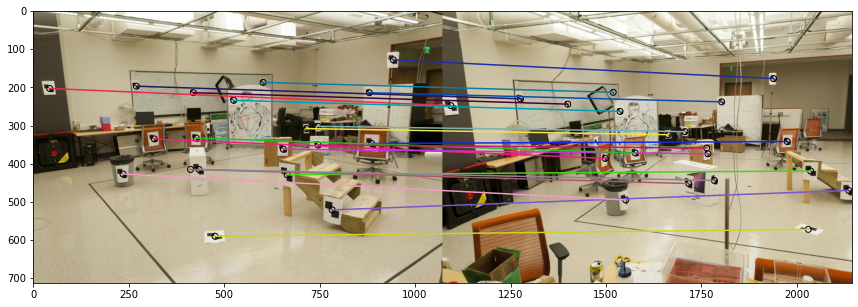

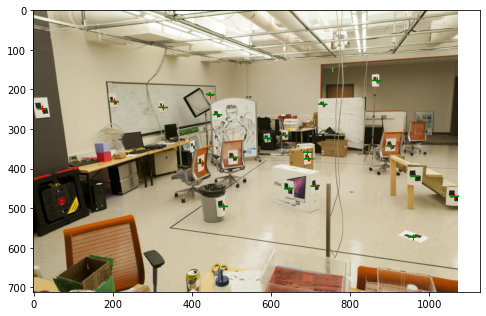

In [294]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import plot_matches

##
## load images and match files for the first example
##

name = "lab"
I1 = imread(f"part2/{name}1.jpg")
I2 = imread(f"part2/{name}2.jpg")
matches = np.loadtxt(f"part2/{name}_matches.txt")

# this is a N x 4 file where the first two numbers of each row
# are coordinates of corners in the first image and the last two
# are coordinates of corresponding corners in the second image:
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is a corresponding point in the second image

N = len(matches)

##
## display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
##

fig, ax = plt.subplots(figsize=(15, 5))
plot_matches(
    ax,
    I1,
    I2,
    matches[:, :2][:, ::-1],
    matches[:, 2:][:, ::-1],
    np.array([(i, i) for i in range(N)]),
)

##
## display second image with epipolar lines reprojected
## from the first image
##

# first, fit fundamental matrix to the matchess
F = fit_fundamental(matches, normalize=True)
print("** F **")
print(F)
print()

# raise RuntimeError
# this is a function that you should write
M = np.c_[matches[:, 0:2], np.ones((N, 1))].transpose()
L1 = (F @ M).T  # transform points from
# the first image to get epipolar lines in the second image

# find points on epipolar lines L closest to matches(:,3:4)
l = np.sqrt(L1[:, 0] ** 2 + L1[:, 1] ** 2)
L = np.divide(L1, np.kron(np.ones((3, 1)), l).transpose())  # rescale the line
pt_line_dist = np.multiply(L, np.c_[matches[:, 2:4], np.ones((N, 1))]).sum(axis=1)
closest_pt = matches[:, 2:4] - np.multiply(
    L[:, 0:2], np.kron(np.ones((2, 1)), pt_line_dist).transpose()
)

# calculate residuals
residuals = np.mean(pt_line_dist ** 2)
print(f"residuals={residuals:.6f}px")

# find endpoints of segment on epipolar line (for display purposes)
pt1 = (
    closest_pt - np.c_[L[:, 1], -L[:, 0]] * 10
)  # offset from the closest point is 10 pixels
pt2 = closest_pt + np.c_[L[:, 1], -L[:, 0]] * 10

# display points and segments of corresponding epipolar lines
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect("equal")
ax.imshow(I2)
ax.plot(matches[:, 2], matches[:, 3], "+r")
ax.plot([matches[:, 2], closest_pt[:, 0]], [matches[:, 3], closest_pt[:, 1]], "r")
ax.plot([pt1[:, 0], pt2[:, 0]], [pt1[:, 1], pt2[:, 1]], "g")
plt.show()


## Camera Calibration

In [87]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u - points_2d[:, 0], v - points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual


### **Lab** pair, estimate projection matrix using ground truth 3D points

In [248]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import plot_matches

##
## load match and ground truth files
##

points_2d = [np.loadtxt(f"part2/lab_matches.txt")[:, i : i + 2] for i in (0, 2)]
points_3d = np.loadtxt(f"part2/lab_3d.txt")


def calibrate(points_2d, points_3d):
    n = len(points_2d)

    A1 = np.hstack(
        [
            np.zeros((n, 4)),
            points_3d,
            np.ones((n, 1)),
            -points_2d[:, 1][:, np.newaxis] * points_3d,
            -points_2d[:, 1][:, np.newaxis],
        ]
    )

    A2 = np.hstack(
        [
            points_3d,
            np.ones((n, 1)),
            np.zeros((n, 4)),
            -points_2d[:, 0][:, np.newaxis] * points_3d,
            -points_2d[:, 0][:, np.newaxis],
        ]
    )

    A = np.empty((2 * n, A1.shape[-1]))
    A[0::2, :] = A1
    A[1::2, :] = A2

    _, _, vh = np.linalg.svd(A.T @ A, full_matrices=False)
    if np.isclose(vh[-1, -1], 0):
        return False

    p = vh[-1, :].reshape(-1, 4)

    return p


matrix = []
for points_2d_subset in points_2d:
    m = calibrate(points_2d_subset, points_3d)
    matrix.append(m)
    points_3d_proj, residuals = evaluate_points(m, points_2d_subset, points_3d)

    dist2 = np.mean((points_3d_proj - points_2d_subset) ** 2)
    print(f"residuals={residuals}, avg_dist2={dist2}")


residuals=13.545776180285374, avg_dist2=0.39307573725611594
residuals=15.5449069211823, avg_dist2=0.372832413946974


### Run this to load projection matrix directly for **library**

In [241]:
matrix = [np.loadtxt(f"part2/library{i}_camera.txt") for i in (1, 2)]


## Camera Centers

[ 314.46066397 -305.35739749 -108.94709993]
[ 69.81376444 -61.83898094 -71.18584069]


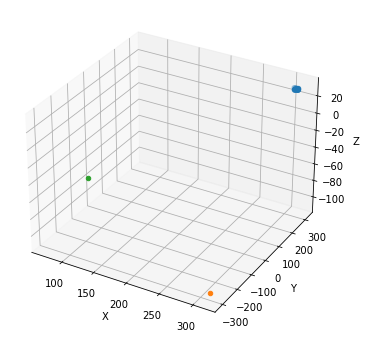

In [247]:
def camera_center(P):
    _, _, vh = np.linalg.svd(P, full_matrices=False)
    if np.isclose(vh[-1, -1], 0):
        return False

    K = vh[-1, :]
    K = K[:3] / K[3]

    return K

# plot lab 3D ground truth
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(*points_3d.T, 'b')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for m in matrix:
    c = camera_center(m)
    print(c)
    ax.scatter(*c, 'r')

## Triangulation

In [291]:
def triangulate(x1, x2, P1, P2):
    M = np.zeros((6,6))
    M[:3,:4] = P1
    M[3:,:4] = P2
    M[:3,4] = -x1
    M[3:,5] = -x2

    _, _, vh = np.linalg.svd(M)
    X = vh[-1,:4]

    X = X[:3] / X[3]

    """
    Xp = np.hstack([X, 1, 0, 0])
    print('Xp=')
    print(Xp)

    Y = M @ Xp
    print('M=')
    print(M)

    print('Y=')
    print(Y)
    print(Y[:2] / Y[2])
    print(Y[3:] / Y[-1])

    Xp = np.hstack([X, 1])
    x1p = P1 @ Xp
    print('x1p=')
    print(x1p / x1p[-1])
    print(x1)
    """

    return X

X = []
for x1, x2 in zip(*points_2d):
    # to homogenous coordinate
    x1 = np.hstack([x1, 1])
    x2 = np.hstack([x2, 1])

    X12 = triangulate(x1, x2, *matrix)
    X.append(X12)

X = np.stack(X, axis=0)

dist2 = np.mean((points_3d - X) ** 2)
print(f"avg_dist2={dist2}")

avg_dist2=0.0002665242531190642
